1.  	Dataset yang digunakan untuk mengklasifikasi gambar apa ?
Jawab : Klasifikasi gambar tingkat kematangan buah pisang, seperti gambar pisang mentah, pisang matang , dan pisang busuk
2.  	Sebutkan jumlah image pada masing – masing kelas ?
Jawab : 240 Image
3.  	Dataset dibagi menjadi berapa Folder dan berapa jumlah masing -  masing ?
Jawab : 80 Image per Folder
4.  	Berapa Batch size yang digunakan ?
Jawab : 62
5.  	Image dataset diubah menjadi ukuran berapa sebelum dilakukan convolution ?
Jawab : 150 150
6.  	Berapa jumlah iterasi yang digunakan ?
Jawab : 50
7.  	sebutkan augmentasi apa saja yang dilakukan dalam pipeline source code yang anda kerjakan ?
Jawab : zoom, rescale, geser, width_shift_range, dan height_shift_range
8.  	sebutkam model layer yang digunakan pada tugas anda ?
Jawab : Conv2D,Drop Out, Batch Normalization dan MaxPooling2D
9.  	optimizer yang digunakan pada tugas anda ?
Jawab : Adam
10.   Berapa total parameter yang digunakan dan parameter yang ditrain ?
Jawab : 5 Parameter
11.   Sebutkan accuracy dan loss pada epoch terakhir ?
Jawab : 0.8800
12.   Sebutkan accuracy yang tertinggi dan epoch ke berapa ?
Jawab : 0.8800, epoch ke 50
13.   Apakah prediksi gambar yang dilakukan sudah benar ?
Jawab : Benar

**Eksperimen**
-        No 1
-        80% train : 10% val : 10% test,  => 0.7500
-        70% train : 15% val : 15% test, => 0.40
-        80% train : 20% val, => 0.9200
-        70% train : 30% => 0.3400

-        No 2 Augmentasi Data => Rotasi dan Horizontal Flip => 0.5500

-        No 3 Batch Size
-           - Batch Size = 20(0.8700)
-           - Batch Size = 50(0.1700)

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [158]:
train_dataset_path = '../input/deeplearningtim16miga/IMAGE CLASSIFICATION LANGIT/TRAIN'
validation_dataset_path = '../input/deeplearningtim16miga/IMAGE CLASSIFICATION LANGIT/VALIDATION'

In [159]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 50

In [160]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                   rotation_range=20,
                                horizontal_flip=True,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 100 images belonging to 3 classes.


In [161]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 100 images belonging to 3 classes.


In [162]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : LANGIT CERAH
1 : LANGIT MENDUNG
2 : SUNSET


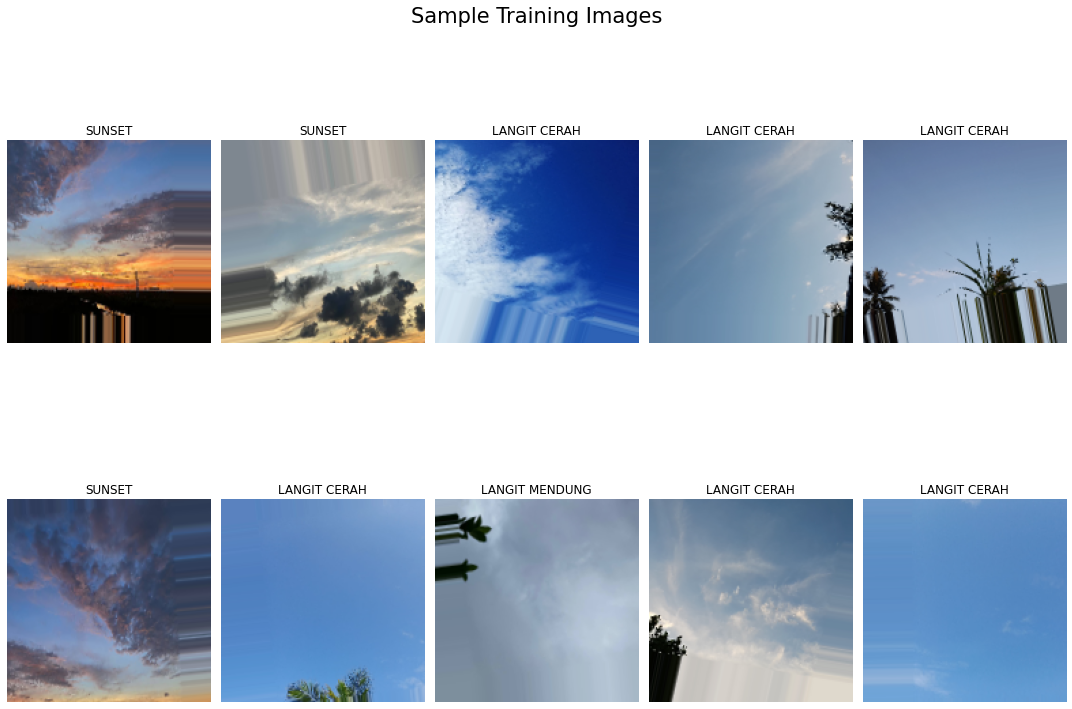

In [163]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [164]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=3, activation='softmax')
    ])
    
    return model

In [165]:
cnn_model = create_model()

In [166]:
print(cnn_model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 146, 146, 128)     9728      
_________________________________________________________________
activation_18 (Activation)   (None, 146, 146, 128)     0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 73, 73, 128)       0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 73, 73, 128)       512       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 71, 71, 64)        73792     
_________________________________________________________________
activation_19 (Activation)   (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 35, 35, 64)       

In [167]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [168]:
optimizer = Adam(learning_rate=0.001)

In [169]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.92):
      print("\nAkurasi di atas 90%, hentikan training!")
      self.model.stop_training = True

In [170]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    ModelCheckpoint(filepath='model.hdf5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True),
    #ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5),
    myCallback()
]

In [171]:
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [172]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2, callbacks = [callbacks])

Epoch 1/50
2/2 - 34s - loss: 1.4994 - accuracy: 0.5400 - val_loss: 1.0321 - val_accuracy: 0.5100

Epoch 00001: val_accuracy improved from -inf to 0.51000, saving model to model.hdf5
Epoch 2/50
2/2 - 27s - loss: 1.6566 - accuracy: 0.7400 - val_loss: 0.8291 - val_accuracy: 0.7100

Epoch 00002: val_accuracy improved from 0.51000 to 0.71000, saving model to model.hdf5
Epoch 3/50
2/2 - 27s - loss: 0.7743 - accuracy: 0.8500 - val_loss: 0.6851 - val_accuracy: 0.7500

Epoch 00003: val_accuracy improved from 0.71000 to 0.75000, saving model to model.hdf5
Epoch 4/50
2/2 - 26s - loss: 0.5805 - accuracy: 0.9100 - val_loss: 0.5912 - val_accuracy: 0.8000

Epoch 00004: val_accuracy improved from 0.75000 to 0.80000, saving model to model.hdf5
Epoch 5/50
2/2 - 26s - loss: 0.6728 - accuracy: 0.8900 - val_loss: 0.5993 - val_accuracy: 0.8000

Epoch 00005: val_accuracy did not improve from 0.80000
Epoch 6/50
2/2 - 26s - loss: 0.1383 - accuracy: 0.9500 - val_loss: 0.6877 - val_accuracy: 0.8000

Epoch 00006:

In [173]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

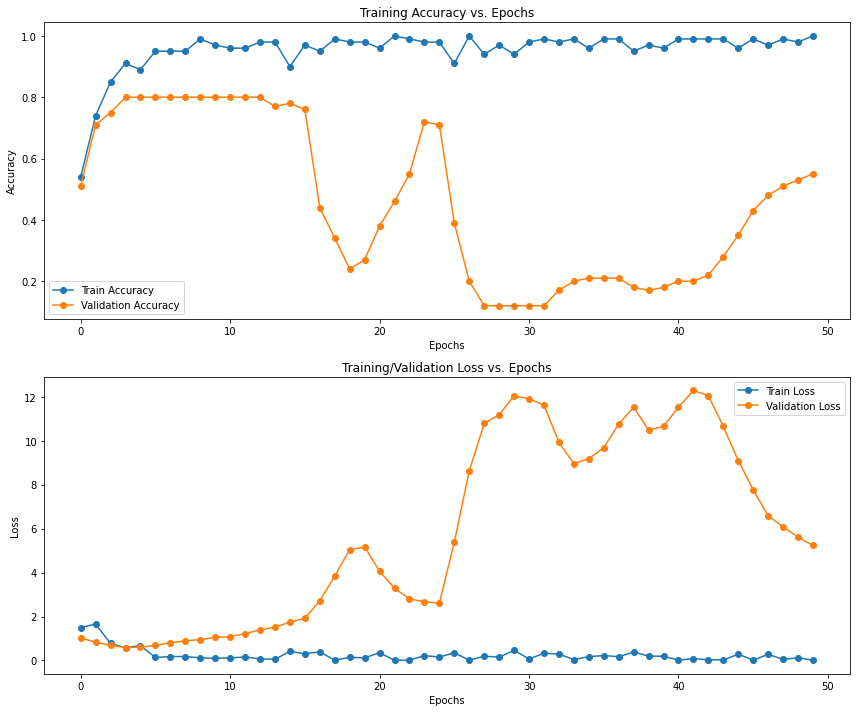

In [174]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [175]:
test_dataset = '../input/deeplearningtim16miga/IMAGE CLASSIFICATION LANGIT/TEST'

In [176]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 100 images belonging to 3 classes.


In [177]:
predictions = cnn_model.predict(test_generator)

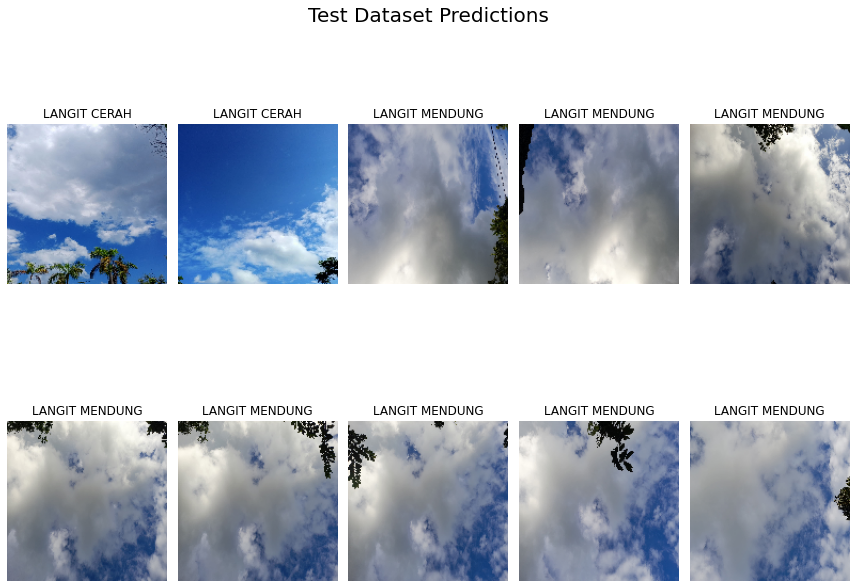

In [178]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [179]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

2/2 [==============================] - 13s 5s/step - loss: 5.2360 - accuracy: 0.5500


In [180]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     5.235977649688721
Test Accuracy: 0.550000011920929


In [181]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [182]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                precision    recall  f1-score   support

  LANGIT CERAH       0.88      0.56      0.69        80
LANGIT MENDUNG       0.20      1.00      0.34        10
        SUNSET       0.00      0.00      0.00        10

      accuracy                           0.55       100
     macro avg       0.36      0.52      0.34       100
  weighted avg       0.73      0.55      0.58       100

